In [309]:
import ToolBox as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [310]:
df= pd.read_csv ('Data_2/ds_salaries.csv')

In [311]:
conteo_valores = df['job_title'].value_counts()

# Calcular el porcentaje de apariciones de cada valor único
porcentaje_apariciones = conteo_valores / len(df) * 100

# Filtrar los valores con porcentaje mayor al 1%
valores_filtrados = porcentaje_apariciones[porcentaje_apariciones > 1].index

# Imprimir los valores filtrados
print(valores_filtrados.tolist())


['Data Engineer', 'Data Scientist', 'Data Analyst', 'Machine Learning Engineer', 'Analytics Engineer', 'Data Architect', 'Research Scientist', 'Data Science Manager', 'Applied Scientist']


In [312]:
# Obtener el conteo de valores únicos en la columna 'job_title'
conteo_valores = df['job_title'].value_counts()

# Calcular el porcentaje de apariciones de cada valor único
porcentaje_apariciones = conteo_valores / len(df) * 100

# Filtrar los nombres de valores únicos con porcentaje mayor al 1%
valores_filtrados = porcentaje_apariciones[porcentaje_apariciones > 1].index

# Filtrar el DataFrame original df
df = df[df['job_title'].isin(valores_filtrados)]



In [313]:
# Obtener las ubicaciones filtradas que tienen más de 10 apariciones
ubicaciones_filtradas = df['company_location'].value_counts()[lambda x: x > 10].index.tolist()

# Filtrar el DataFrame para mantener solo las filas de las ubicaciones filtradas
df = df[df['company_location'].isin(ubicaciones_filtradas)]


In [314]:
# Definir los límites de los rangos (bins) y las etiquetas
bins = [0, 30000, 50000, 75000, 100000, 150000, 200000, float('inf')]
labels = ['<30000', '30001-50000', '50001-75000', '75001-100000', '100001-150000', '150001-200000', '>200000']

# Aplicar pd.cut() para segmentar los precios en los bins y asignar las etiquetas
df['rango_precio'] = pd.cut(df['salary_in_usd'], bins=bins, labels=labels, right=False)

df = df.drop (['salary_in_usd', 'salary', 'salary_currency'], axis=1)

df.head (5)


work_year experience_level employment_type          job_title  \
3       2023               SE              FT     Data Scientist   
4       2023               SE              FT     Data Scientist   
5       2023               SE              FT  Applied Scientist   
6       2023               SE              FT  Applied Scientist   
7       2023               SE              FT     Data Scientist   

  employee_residence  remote_ratio company_location company_size  \
3                 CA           100               CA            M   
4                 CA           100               CA            M   
5                 US             0               US            L   
6                 US             0               US            L   
7                 CA             0               CA            M   

    rango_precio  
3  150001-200000  
4  100001-150000  
5        >200000  
6  100001-150000  
7        >200000

In [315]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

def get_features_cat_classification_2(df, target_col, normalize=False, mi_threshold=0.0):
    """
    Selecciona columnas categóricas cuyo valor de mutual information con la columna target supere un umbral.

    Argumentos:
    df (pd.DataFrame): DataFrame de entrada.
    target_col (str): Nombre de la columna target.
    normalize (bool): Si es True, se normaliza el valor de mutual information. Por defecto es False.
    mi_threshold (float): Umbral para el valor de mutual information. Por defecto es 0.

    Retorna:
    list: Lista de columnas categóricas que cumplen con el criterio de mutual information.
    """
    
    # Verificamos si target_col está en el dataframe
    if target_col not in df.columns:
        raise ValueError("Error: 'target_col' no está en el dataframe.")
    
    # Verificamos si target_col es categórica o numérica discreta con baja cardinalidad
    if not (pd.api.types.is_categorical_dtype(df[target_col]) or pd.api.types.is_object_dtype(df[target_col]) or 
            (pd.api.types.is_numeric_dtype(df[target_col]) and df[target_col].nunique() < 20)):
        raise ValueError("Error: 'target_col' debe ser una variable catególica o numérica discreta con baja cardinalidad.")
    
    # Verificamos si mi_threshold es un float válido
    if not isinstance(mi_threshold, float):
        raise ValueError("Error: 'mi_threshold' debe ser un valor float.")

    # Si normalize es True, verificamos que mi_threshold esté entre 0 y 1
    if normalize and not (0 <= mi_threshold <= 1):
        raise ValueError("Error: 'mi_threshold' debe estar entre 0 y 1 cuando 'normalize' es True.")
    
    # Convertir columnas categóricas a códigos numéricos
    le = LabelEncoder()
    df_categorical = df.select_dtypes(include=['category', 'object'])
    df_categorical_encoded = df_categorical.apply(lambda x: le.fit_transform(x))
    
    # Unir las columnas categóricas convertidas con las columnas numéricas originales
    df_encoded = pd.concat([df.drop(df_categorical.columns, axis=1), df_categorical_encoded], axis=1)
    
    # Calculamos la mutual information para las columnas categóricas convertidas
    cols_categoricas_encoded = df_categorical_encoded.columns.tolist()
    mi_scores = mutual_info_classif(df_encoded[cols_categoricas_encoded], df_encoded[target_col], discrete_features=True)

    if normalize:
        # Normalizamos los valores de mutual information
        mi_scores /= mi_scores.sum()
    
    # Seleccionamos las columnas que cumplen con el umbral
    columnas_significativas = [col for col, mi in zip(cols_categoricas_encoded, mi_scores) if mi >= mi_threshold]

    return columnas_significativas


In [316]:
get_features_cat_classification_2 (df, 'rango_precio')

C:\Users\pobla\AppData\Local\Temp\ipykernel_20836\2805466384.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not (pd.api.types.is_categorical_dtype(df[target_col]) or pd.api.types.is_object_dtype(df[target_col]) or


['experience_level',
 'employment_type',
 'job_title',
 'employee_residence',
 'company_location',
 'company_size',
 'rango_precio']

In [317]:
def plot_features_cat_classification_2 (df, target_col="", columns=[], mi_threshold=0.0, normalize=False):
    
    """
    Pinta las distribuciones de las columnas categoricas que pasan un threshold de informacion mutua con respecto a una columna objetivo haciendo uso de la funcionget_features_cat_classification
    
    Parámetros: 
    - df->dataframe objetivo 
    - target_col->columna(s) objetivo, pueden ser varias
    - mi_threshold->limite usado para la comprobacion de informacion mutua de las columnas
    - normalize->booleano que indica si se ha de normalizar o no a la hora de comprobar la informacion mutua
    
    Rertorna:
    - Plots de las variables que han pasado el limite de informacion mutua, representando la relacion entre esa columna y la columna objetivo
    """
    if not isinstance(df, pd.DataFrame):
        print("El dataframe proporcionado en realidad no es un dataframe")
        return None
    
    if target_col == "":
        print("Especifica una columna")
        return None
    
    if target_col not in df.columns:
        print(f"La columna '{target_col}' no esta en el datarame")
        return None

    if not isinstance(df[target_col].dtype, pd.CategoricalDtype):
        df[target_col] = df[target_col].astype('category')
    
    if not columns:
        columns = df.select_dtypes(include=['category', 'object']).columns.tolist()
        if target_col in columns:
            columns.remove(target_col)
    
    if not all(col in df.columns for col in columns):
        print("Comprueba que todas las columnas espeficadas esten en el dataframe")
        return None
    
    selected_columns = get_features_cat_classification_2(df, target_col, normalize, mi_threshold)
    
    if not selected_columns:
        print("Ninguna columna cumple con la condicion de la informacion mutua")
        return None
    
    for col in selected_columns:
        plt.figure(figsize=(10, 6))
        df.groupby([col, target_col]).size().unstack().plot(kind='bar', stacked=True)
        plt.title(f'Distribucion de {target_col} con {col}')
        plt.xlabel(col)
        plt.ylabel('Contador')
        plt.legend(title=target_col)
        plt.show()

C:\Users\pobla\AppData\Local\Temp\ipykernel_20836\2805466384.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not (pd.api.types.is_categorical_dtype(df[target_col]) or pd.api.types.is_object_dtype(df[target_col]) or
C:\Users\pobla\AppData\Local\Temp\ipykernel_20836\4048680677.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([col, target_col]).size().unstack().plot(kind='bar', stacked=True)


<Figure size 1000x600 with 0 Axes>

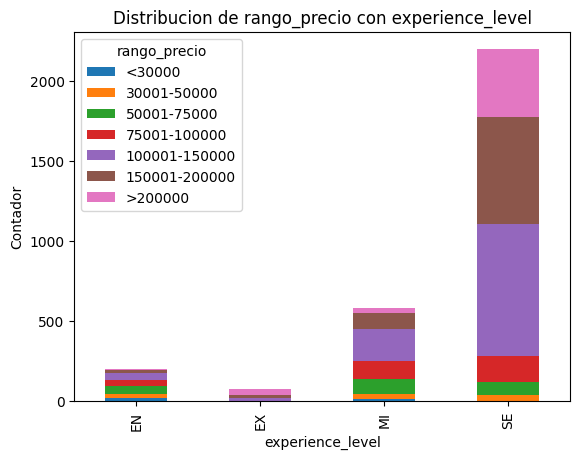

C:\Users\pobla\AppData\Local\Temp\ipykernel_20836\4048680677.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([col, target_col]).size().unstack().plot(kind='bar', stacked=True)


<Figure size 1000x600 with 0 Axes>

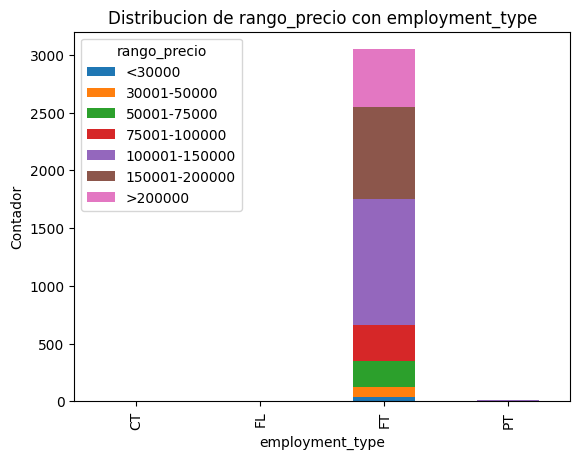

C:\Users\pobla\AppData\Local\Temp\ipykernel_20836\4048680677.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([col, target_col]).size().unstack().plot(kind='bar', stacked=True)


<Figure size 1000x600 with 0 Axes>

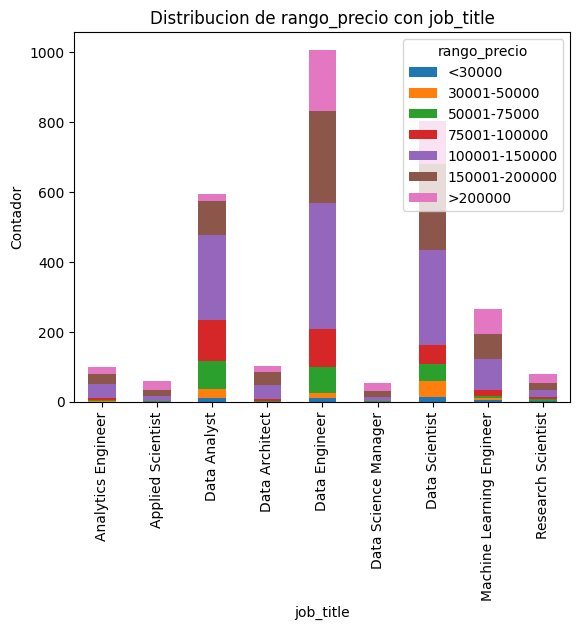

C:\Users\pobla\AppData\Local\Temp\ipykernel_20836\4048680677.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([col, target_col]).size().unstack().plot(kind='bar', stacked=True)


<Figure size 1000x600 with 0 Axes>

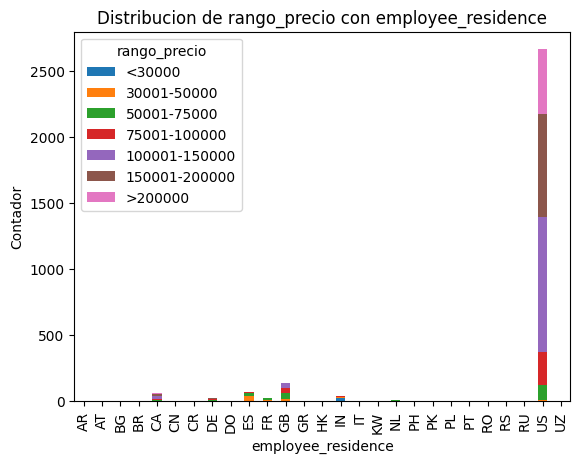

C:\Users\pobla\AppData\Local\Temp\ipykernel_20836\4048680677.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([col, target_col]).size().unstack().plot(kind='bar', stacked=True)


<Figure size 1000x600 with 0 Axes>

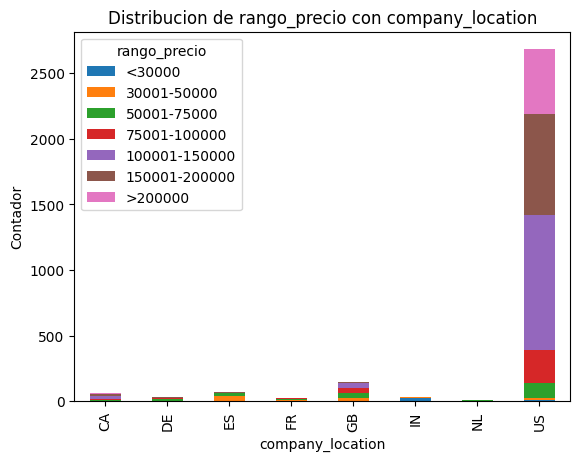

C:\Users\pobla\AppData\Local\Temp\ipykernel_20836\4048680677.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([col, target_col]).size().unstack().plot(kind='bar', stacked=True)


<Figure size 1000x600 with 0 Axes>

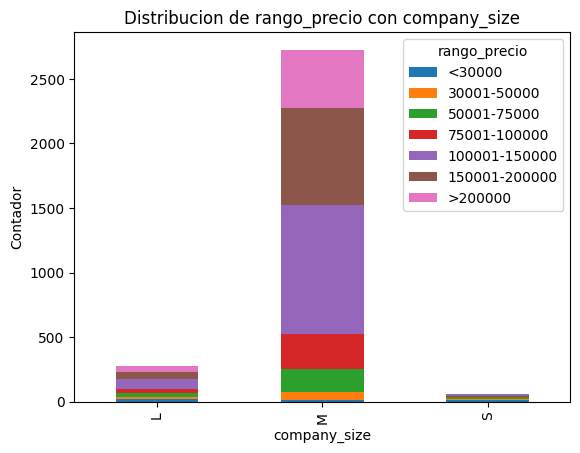

C:\Users\pobla\AppData\Local\Temp\ipykernel_20836\4048680677.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([col, target_col]).size().unstack().plot(kind='bar', stacked=True)


<Figure size 1000x600 with 0 Axes>

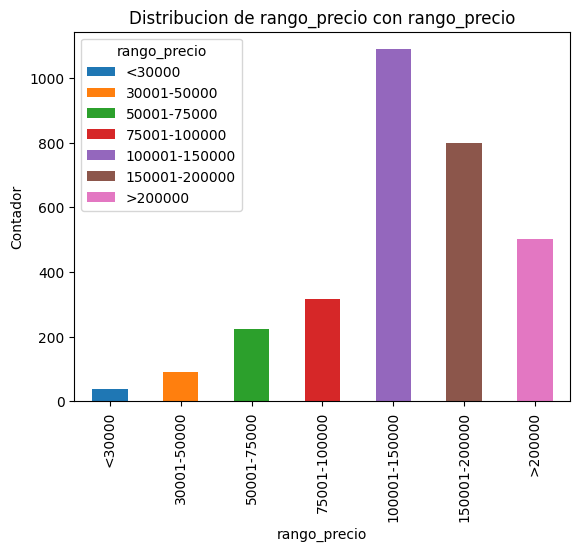

In [318]:
plot_features_cat_classification_2(df, 'rango_precio')

In [319]:
sdfsdfs

NameError: name 'sdfsdfs' is not defined

In [ ]:
X = df ['job_title']
X = pd.get_dummies(X, columns=['job_title'], drop_first=True)

X

AI Developer  AI Engineer  AI Product Manager  AI Programmer  \
0             False         True               False          False   
1             False         True               False          False   
2             False        False               False          False   
3             False        False               False          False   
4             False        False               False          False   
...             ...          ...                 ...            ...   
16529         False        False               False          False   
16530         False        False               False          False   
16531         False        False               False          False   
16532         False        False               False          False   
16533         False        False               False          False   

       AI Research Engineer  AI Research Scientist  AI Scientist  \
0                     False                  False         False   
1                     False                  False         False   
2                     False                  False         False   
3                     False                  False         False   
4                     False                  False         False   
...                     ...                    ...           ...   
16529                 False                  False         False   
16530                 False                  False         False   
16531                 False                  False         False   
16532                 False                  False         False   
16533                 False                  False         False   

       AI Software Engineer  AWS Data Architect  Admin & Data Analyst  ...  \
0                     False               False                 False  ...   
1                     False               False                 False  ...   
2                     False               False                 False  ...   
3                     False               False                 False  ...   
4                     False               False                 False  ...   
...                     ...                 ...                   ...  ...   
16529                 False               False                 False  ...   
16530                 False               False                 False  ...   
16531                 False               False                 False  ...   
16532                 False               False                 False  ...   
16533                 False               False                 False  ...   

       Research Analyst  Research Engineer  Research Scientist  \
0                 False              False               False   
1                 False              False               False   
2                 False              False               False   
3                 False              False               False   
4                 False              False               False   
...                 ...                ...                 ...   
16529             False              False               False   
16530             False              False               False   
16531             False              False               False   
16532             False              False               False   
16533             False              False               False   

       Robotics Engineer  Robotics Software Engineer  Sales Data Analyst  \
0                  False                       False               False   
1                  False                       False               False   
2                  False                       False               False   
3                  False                       False               False   
4                  False                       False               False   
...                  ...                         ...                 ...   
16529              False                       False               False   

RMSE: 2085278484057690.0
MAE: 38972598594131.9


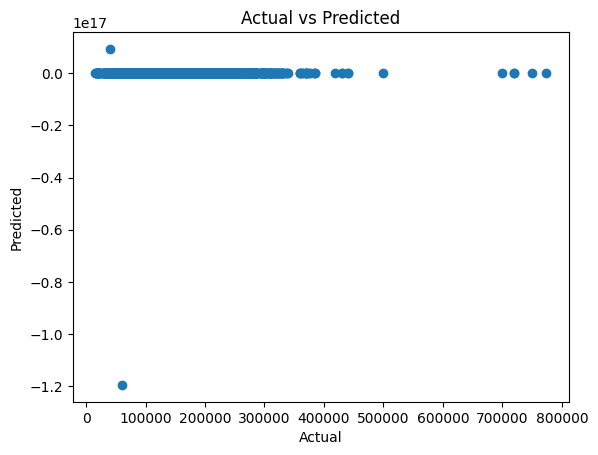

(2085278484057690.0, 38972598594131.9)

In [ ]:

y = df['salary_in_usd']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

tb.eval_model (y_test, pred, 'regression', ['RMSE', 'MAE', 'GRAPH'])



In [ ]:
tb.eval_model (df)

TypeError: eval_model() missing 3 required positional arguments: 'predictions', 'problem_type', and 'metrics'

In [ ]:
df = pd.read_csv ('Data_2/lol.csv')

In [ ]:
tb.describe_df (df)

gameId blueWins blueWardsPlaced blueWardsDestroyed  \
DATA_TYPE      int64    int64           int64              int64   
MISSINGS (%)     0.0      0.0             0.0                0.0   
UNIQUE_VALUES   9879        2             147                 27   
CARDIN (%)     100.0     0.02            1.49               0.27   

              blueFirstBlood blueKills blueDeaths blueAssists  \
DATA_TYPE              int64     int64      int64       int64   
MISSINGS (%)             0.0       0.0        0.0         0.0   
UNIQUE_VALUES              2        21         21          30   
CARDIN (%)              0.02      0.21       0.21         0.3   

              blueEliteMonsters blueDragons  ... redTowersDestroyed  \
DATA_TYPE                 int64       int64  ...              int64   
MISSINGS (%)                0.0         0.0  ...                0.0   
UNIQUE_VALUES                 3           2  ...                  3   
CARDIN (%)                 0.03        0.02  ...               0.03   

              redTotalGold redAvgLevel redTotalExperience  \
DATA_TYPE            int64     float64              int64   
MISSINGS (%)           0.0         0.0                0.0   
UNIQUE_VALUES         4732          18               4113   
CARDIN (%)            47.9        0.18              41.63   

              redTotalMinionsKilled redTotalJungleMinionsKilled redGoldDiff  \
DATA_TYPE                     int64                       int64       int64   
MISSINGS (%)                    0.0                         0.0         0.0   
UNIQUE_VALUES                   153                          75        6047   
CARDIN (%)                     1.55                        0.76       61.21   

              redExperienceDiff redCSPerMin redGoldPerMin  
DATA_TYPE                 int64     float64       float64  
MISSINGS (%)                0.0         0.0           0.0  
UNIQUE_VALUES              5356         153          4732  
CARDIN (%)                54.22        1.55          47.9  

[4 rows x 40 columns]

In [ ]:
df['blueWins'] = df['blueWins'].replace({0: 'derrota', 1: 'victoria'})

In [ ]:
df.head (5)

gameId blueWins  blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  \
0  4519157822  derrota               28                   2               1   
1  4523371949  derrota               12                   1               0   
2  4521474530  derrota               15                   0               0   
3  4524384067  derrota               43                   1               0   
4  4436033771  derrota               75                   4               0   

   blueKills  blueDeaths  blueAssists  blueEliteMonsters  blueDragons  ...  \
0          9           6           11                  0            0  ...   
1          5           5            5                  0            0  ...   
2          7          11            4                  1            1  ...   
3          4           5            5                  1            0  ...   
4          6           6            6                  0            0  ...   

   redTowersDestroyed  redTotalGold  redAvgLevel  redTotalExperience  \
0                   0         16567          6.8               17047   
1                   1         17620          6.8               17438   
2                   0         17285          6.8               17254   
3                   0         16478          7.0               17961   
4                   0         17404          7.0               18313   

   redTotalMinionsKilled  redTotalJungleMinionsKilled  redGoldDiff  \
0                    197                           55         -643   
1                    240                           52         2908   
2                    203                           28         1172   
3                    235                           47         1321   
4                    225                           67         1004   

   redExperienceDiff  redCSPerMin  redGoldPerMin  
0                  8         19.7         1656.7  
1               1173         24.0         1762.0  
2               1033         20.3         1728.5  
3                  7         23.5         1647.8  
4               -230         22.5         1740.4  

[5 rows x 40 columns]

Accuracy: 0.7226720647773279
Precision: 0.7226649619564828
Recall: 0.7226649619564828
Classification Report:
               precision    recall  f1-score   support

     derrota       0.72      0.72      0.72       983
    victoria       0.72      0.72      0.72       993

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976



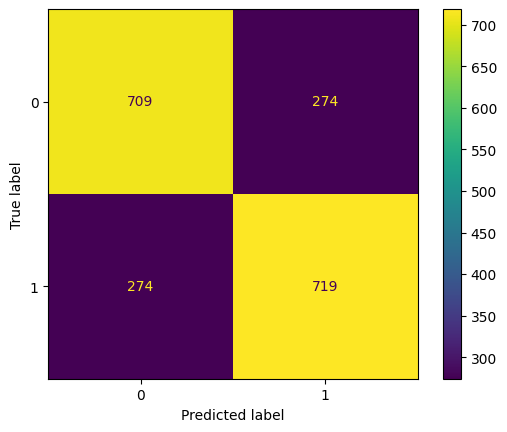

(0.7226720647773279, 0.7226649619564828, 0.7226649619564828)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier


X = df.drop ('blueWins', axis=1)
y = df['blueWins']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression ()
model.fit(X_train, y_train)
pred = model.predict(X_test)

tb.eval_model (y_test, pred, 'classification', ['ACCURACY', 'PRECISION', 'RECALL',  'CLASS_REPORT', 'MATRIX' ])

In [ ]:
df

gameId  blueWins  blueWardsPlaced  blueWardsDestroyed  \
0     4519157822   derrota               28                   2   
1     4523371949   derrota               12                   1   
2     4521474530   derrota               15                   0   
3     4524384067   derrota               43                   1   
4     4436033771   derrota               75                   4   
...          ...       ...              ...                 ...   
9874  4527873286  victoria               17                   2   
9875  4527797466  victoria               54                   0   
9876  4527713716   derrota               23                   1   
9877  4527628313   derrota               14                   4   
9878  4523772935  victoria               18                   0   

      blueFirstBlood  blueKills  blueDeaths  blueAssists  blueEliteMonsters  \
0                  1          9           6           11                  0   
1                  0          5           5            5                  0   
2                  0          7          11            4                  1   
3                  0          4           5            5                  1   
4                  0          6           6            6                  0   
...              ...        ...         ...          ...                ...   
9874               1          7           4            5                  1   
9875               0          6           4            8                  1   
9876               0          6           7            5                  0   
9877               1          2           3            3                  1   
9878               1          6           6            5                  0   

      blueDragons  ...  redTowersDestroyed  redTotalGold  redAvgLevel  \
0               0  ...                   0         16567          6.8   
1               0  ...                   1         17620          6.8   
2               1  ...                   0         17285          6.8   
3               0  ...                   0         16478          7.0   
4               0  ...                   0         17404          7.0   
...           ...  ...                 ...           ...          ...   
9874            1  ...                   0         15246          6.8   
9875            1  ...                   0         15456          7.0   
9876            0  ...                   0         18319          7.4   
9877            1  ...                   0         15298          7.2   
9878            0  ...                   0         15339          6.8   

      redTotalExperience  redTotalMinionsKilled  redTotalJungleMinionsKilled  \
0                  17047                    197                           55   
1                  17438                    240                           52   
2                  17254                    203                           28   
3                  17961                    235                           47   
4                  18313                    225                           67   
...                  ...                    ...                          ...   
9874               16498                    229                           34   
9875               18367                    206                           56   
9876               19909                    261                           60   
9877               18314                    247                           40   
9878               17379                    201                           46   

      redGoldDiff  redExperienceDiff  redCSPerMin  redGoldPerMin  
0            -643                  8         19.7         1656.7  
1            2908               1173         24.0         1762.0  
2            1172               1033         20.3         1728.5  
3            1321                  7         23.5         1647.8  
4            1004               -230         22.5         1740.4  
...           ..

In [ ]:
import pprint as p
lista_func =  (tb.get_features_num_classification (df, 'blueWins'))

In [ ]:
lista_func

['gameId',
 'blueWardsDestroyed',
 'blueFirstBlood',
 'blueKills',
 'blueDeaths',
 'blueAssists',
 'blueEliteMonsters',
 'blueDragons',
 'blueHeralds',
 'blueTowersDestroyed',
 'blueTotalGold',
 'blueAvgLevel',
 'blueTotalExperience',
 'blueTotalMinionsKilled',
 'blueTotalJungleMinionsKilled',
 'blueGoldDiff',
 'blueExperienceDiff',
 'blueCSPerMin',
 'blueGoldPerMin',
 'redWardsPlaced',
 'redWardsDestroyed',
 'redFirstBlood',
 'redKills',
 'redDeaths',
 'redAssists',
 'redEliteMonsters',
 'redDragons',
 'redHeralds',
 'redTowersDestroyed',
 'redTotalGold',
 'redAvgLevel',
 'redTotalExperience',
 'redTotalMinionsKilled',
 'redTotalJungleMinionsKilled',
 'redGoldDiff',
 'redExperienceDiff',
 'redCSPerMin',
 'redGoldPerMin']

In [ ]:
lista_origin = df.columns

In [ ]:
set1 = set(lista_origin)
set2 = set(lista_func)


diff1 = set1 - set2

diff2 = set2 - set1

differences = diff1.union(diff2)

print("Valores diferentes entre las dos listas:", differences)

Valores diferentes entre las dos listas: {'blueWins', 'blueWardsPlaced'}


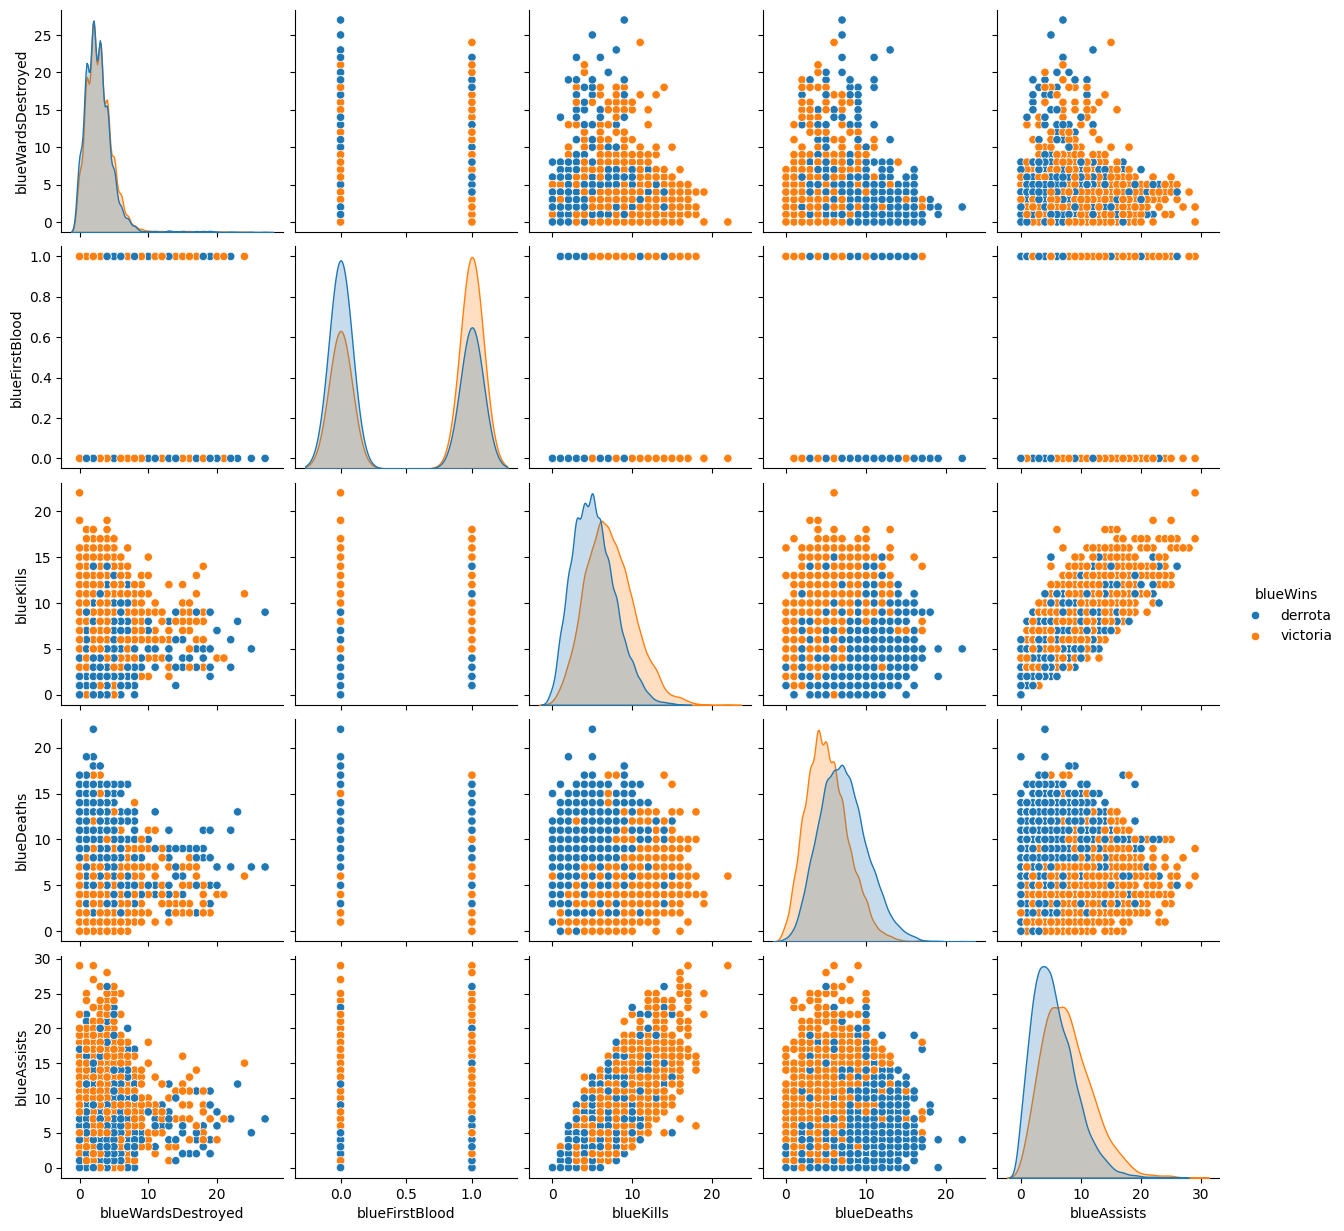

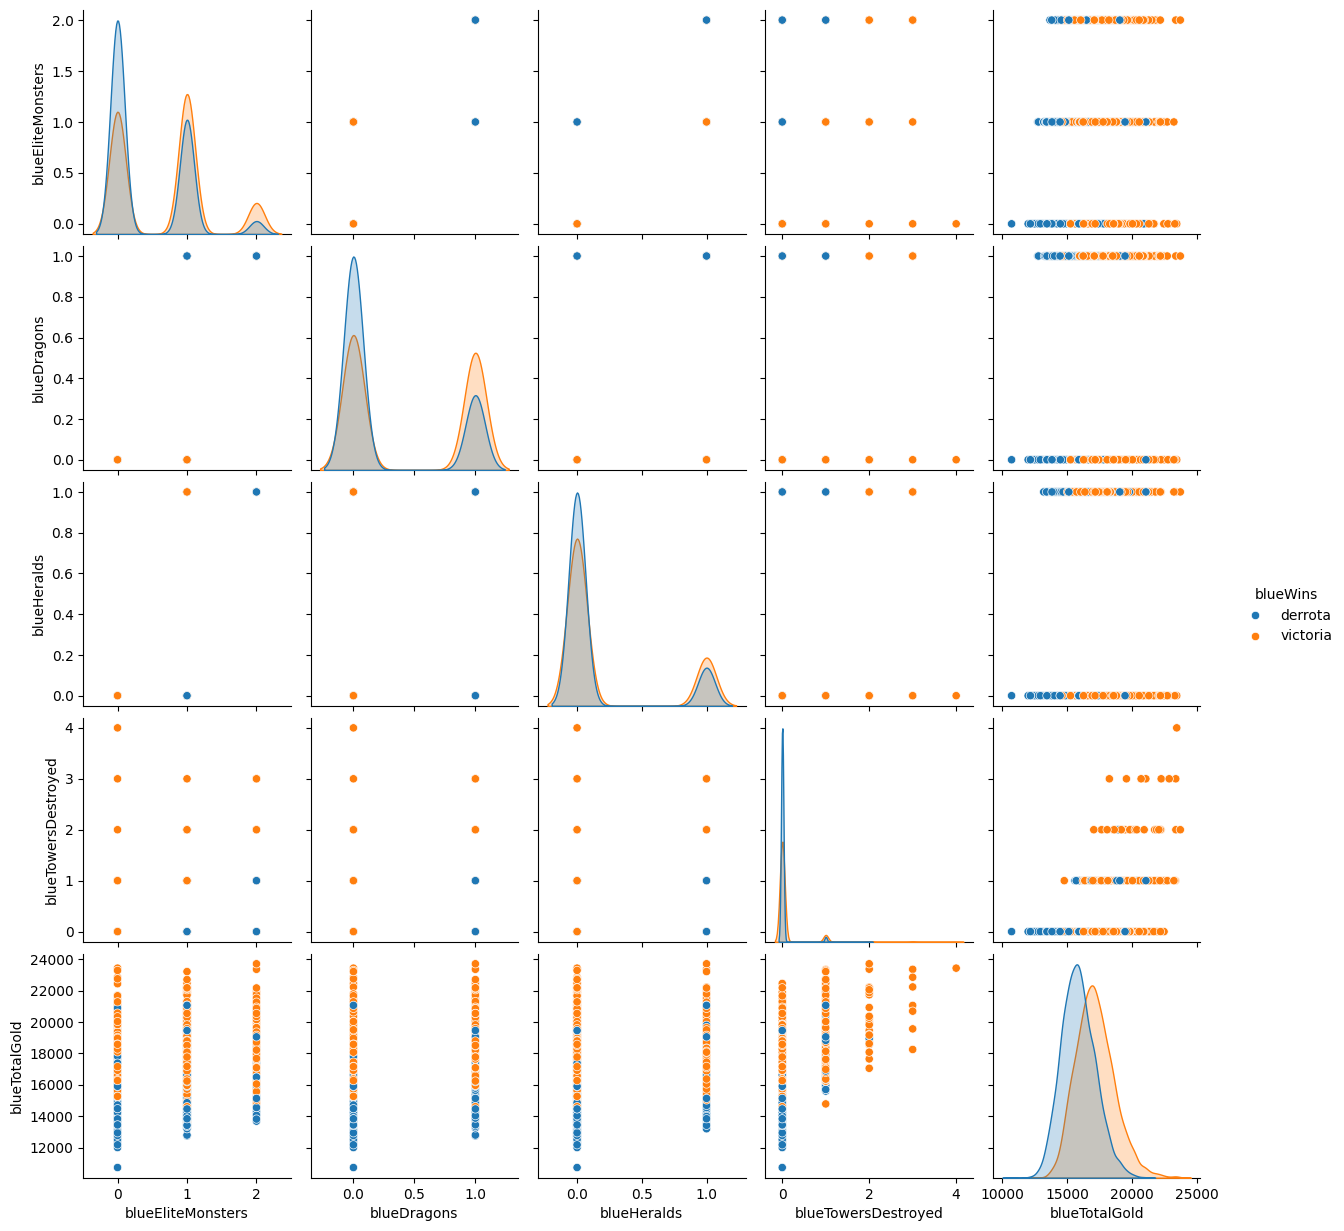

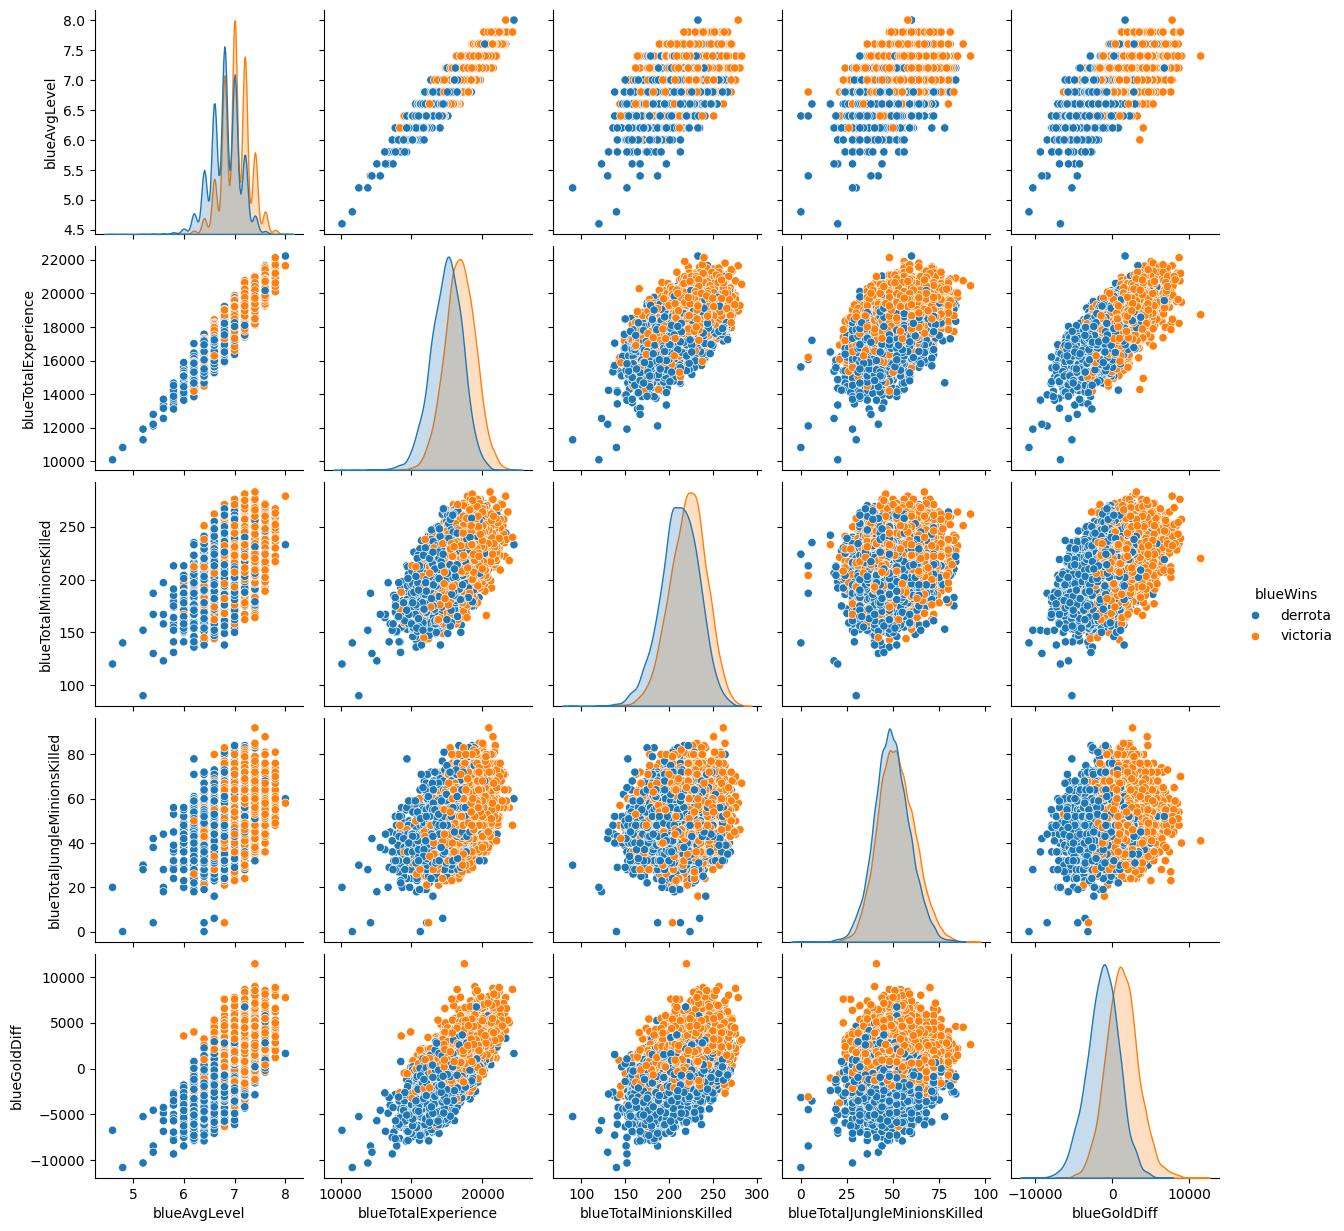

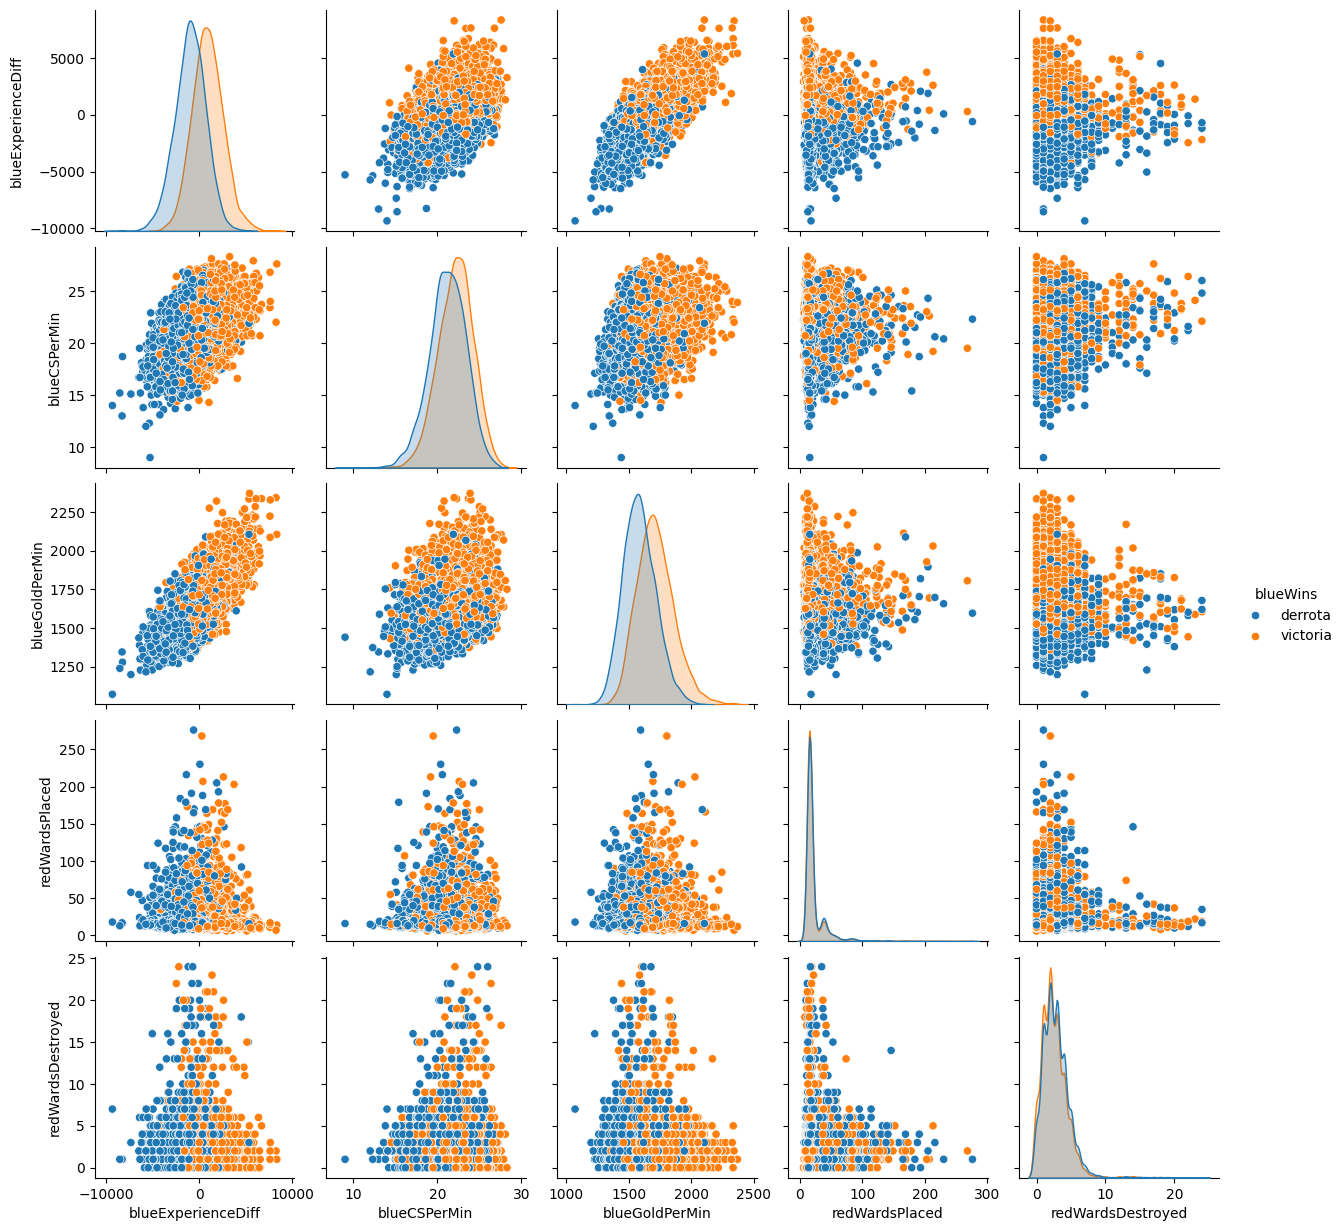

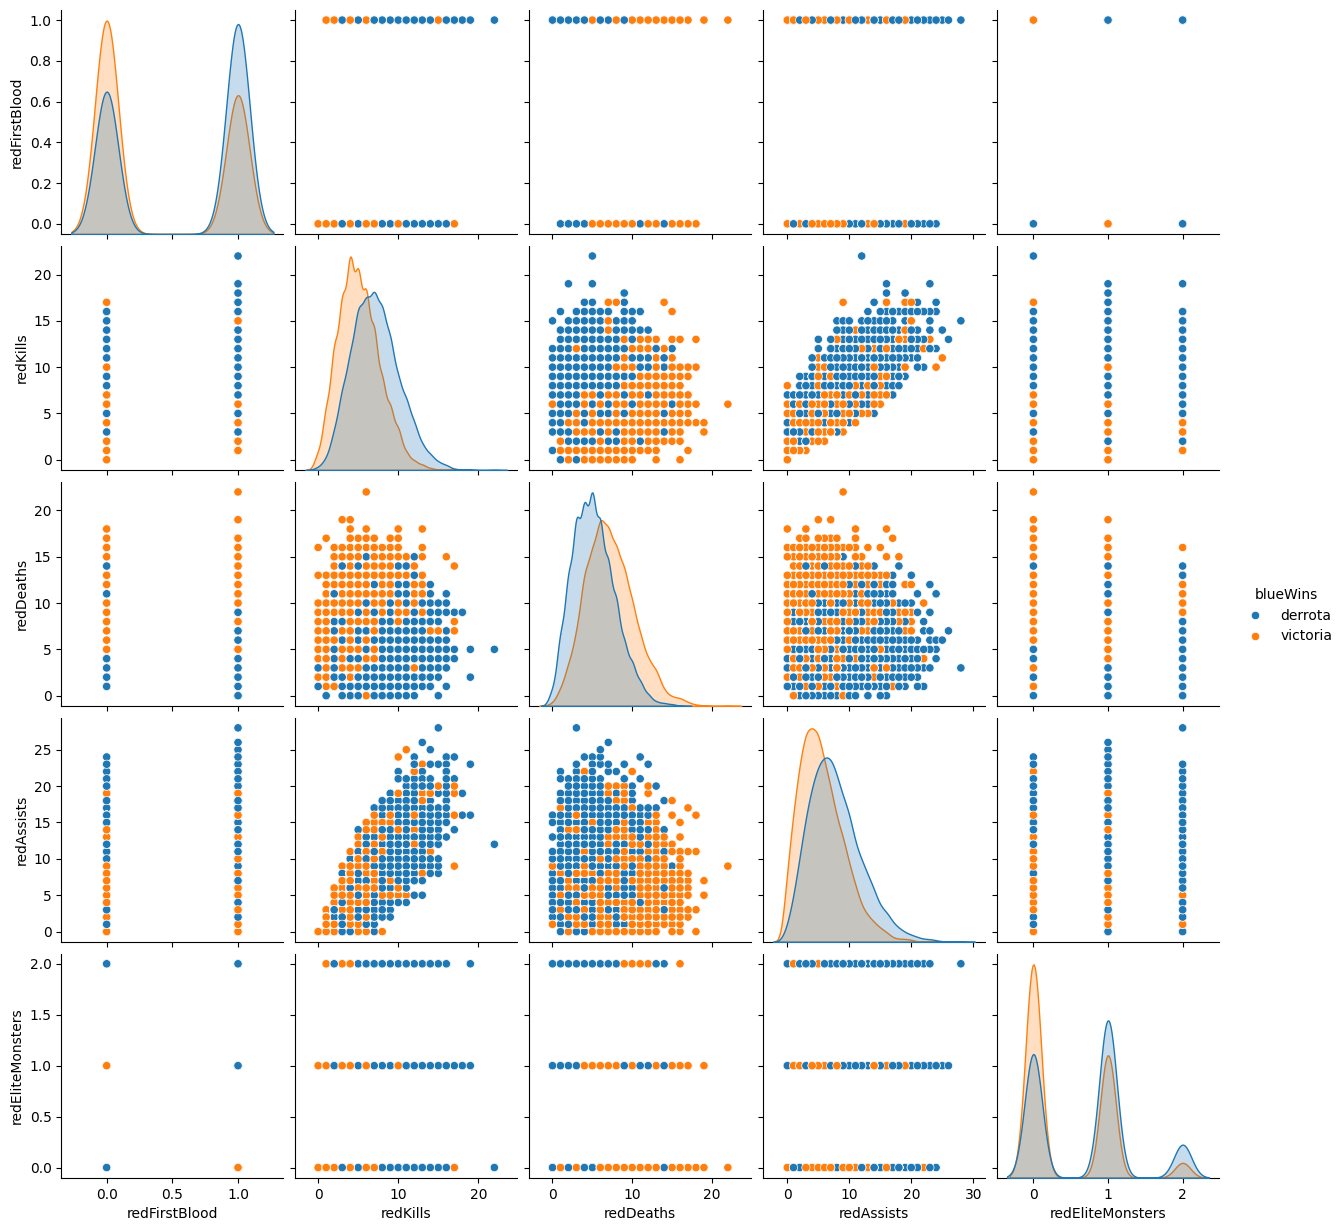

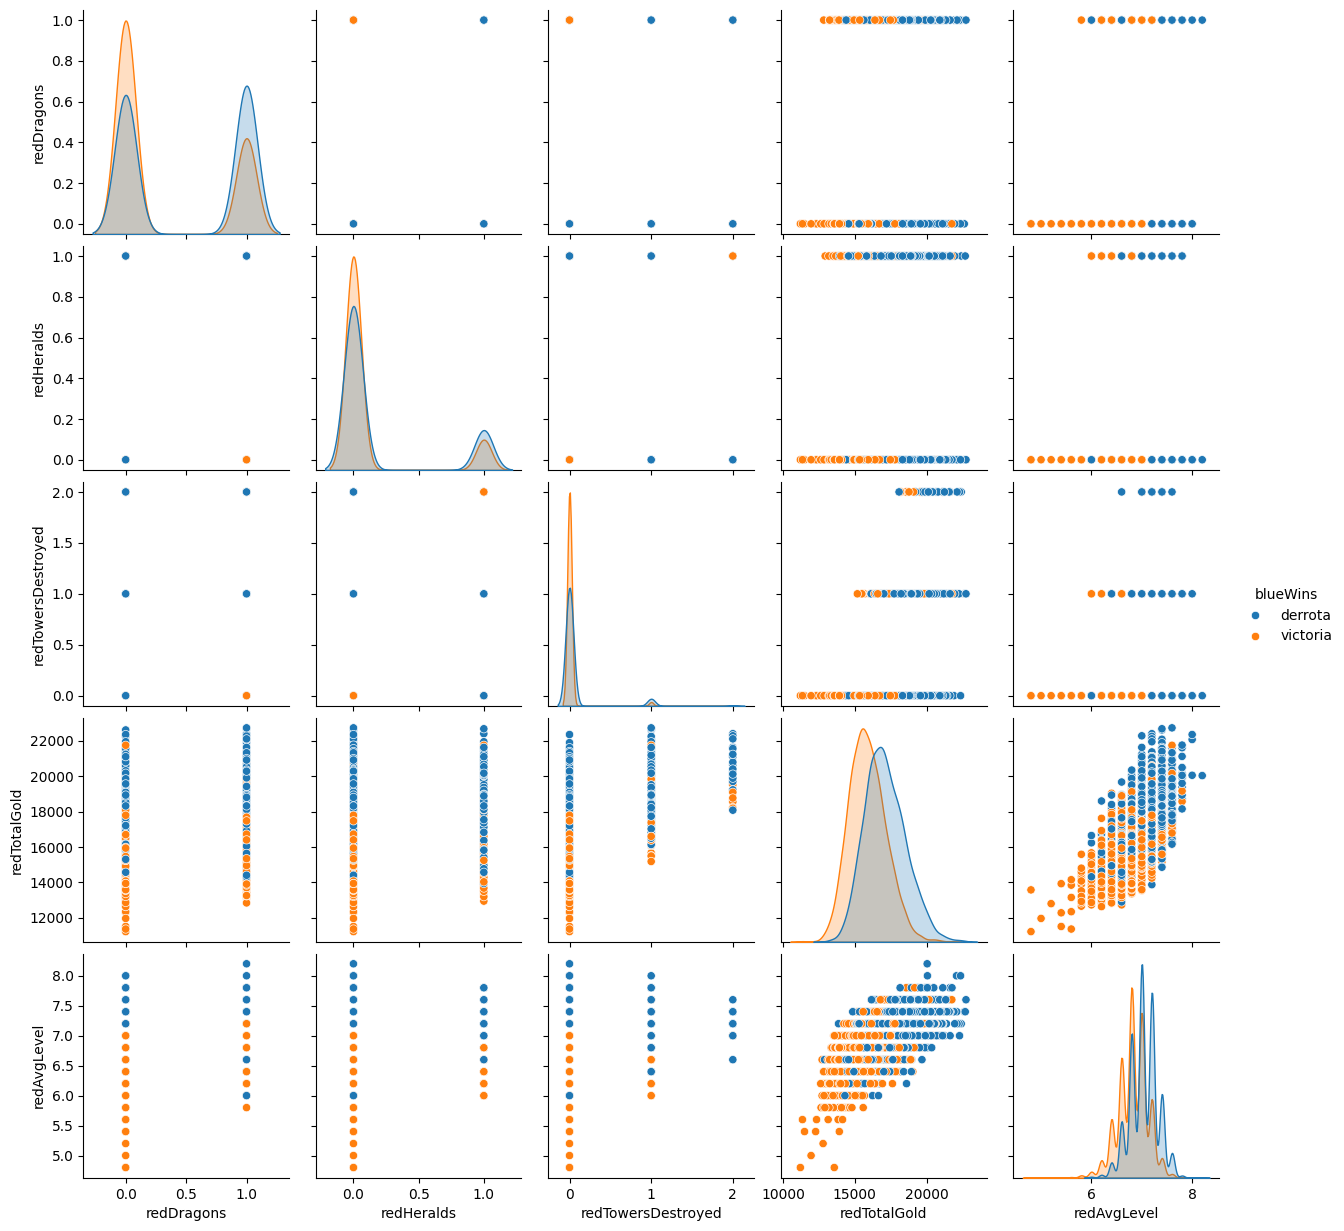

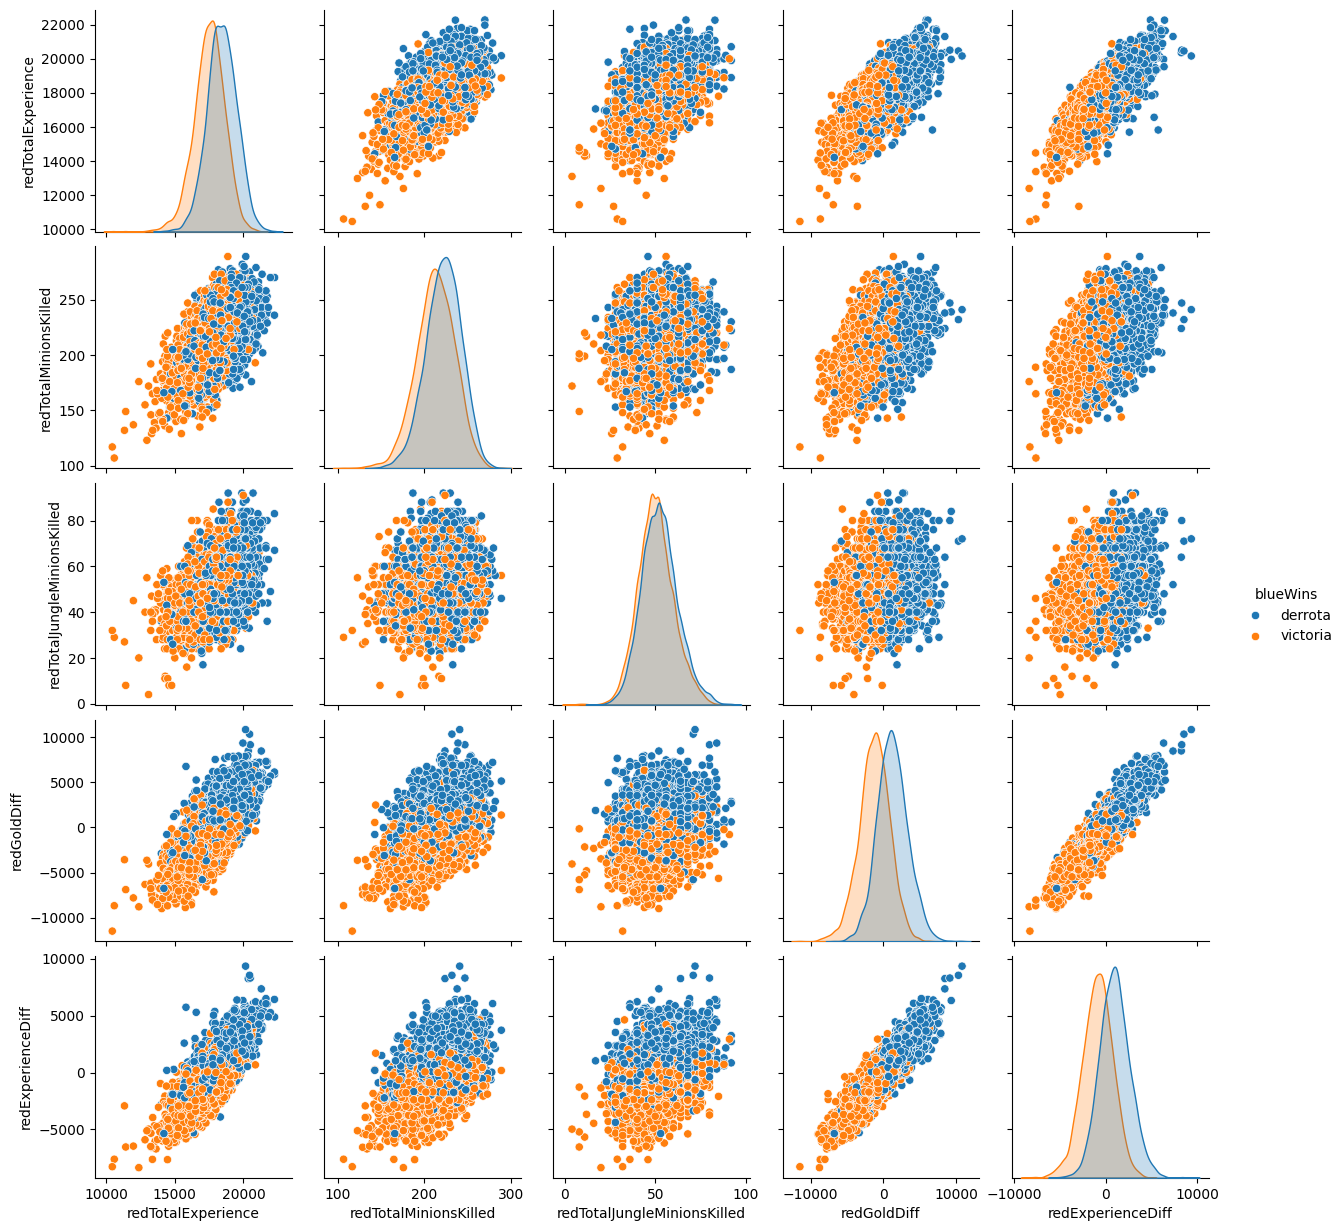

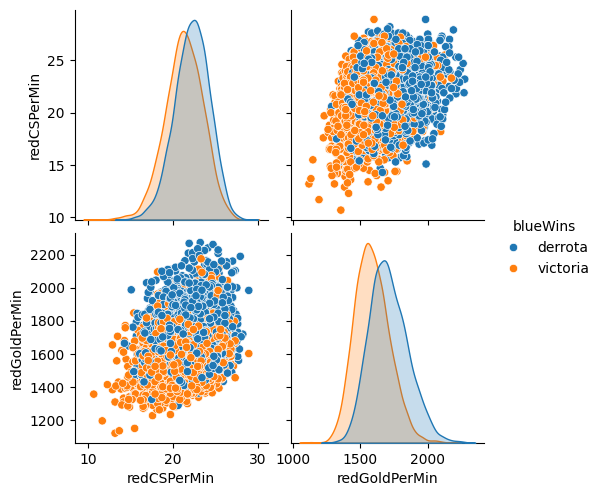

['blueWardsDestroyed',
 'blueFirstBlood',
 'blueKills',
 'blueDeaths',
 'blueAssists',
 'blueEliteMonsters',
 'blueDragons',
 'blueHeralds',
 'blueTowersDestroyed',
 'blueTotalGold',
 'blueAvgLevel',
 'blueTotalExperience',
 'blueTotalMinionsKilled',
 'blueTotalJungleMinionsKilled',
 'blueGoldDiff',
 'blueExperienceDiff',
 'blueCSPerMin',
 'blueGoldPerMin',
 'redWardsPlaced',
 'redWardsDestroyed',
 'redFirstBlood',
 'redKills',
 'redDeaths',
 'redAssists',
 'redEliteMonsters',
 'redDragons',
 'redHeralds',
 'redTowersDestroyed',
 'redTotalGold',
 'redAvgLevel',
 'redTotalExperience',
 'redTotalMinionsKilled',
 'redTotalJungleMinionsKilled',
 'redGoldDiff',
 'redExperienceDiff',
 'redCSPerMin',
 'redGoldPerMin']

In [ ]:
tb.plot_features_num_classification (df, 'blueWins')

In [ ]:
df = pd.read_csv ('Data_2/insurance.csv')

In [ ]:
df.head ()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [ ]:
df = df.drop ('region', axis=1)

In [ ]:
df =  pd.get_dummies(df, columns=['sex', 'smoker'], drop_first=True)

RMSE: 5829.17293025419
MAE: 4213.484797807139


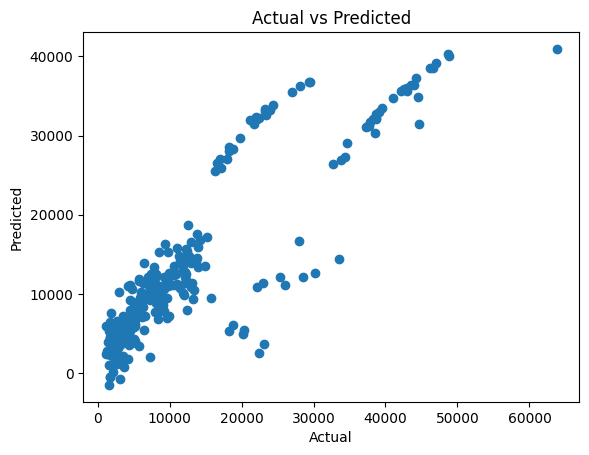

(5829.17293025419, 4213.484797807139)

In [ ]:
X = df.drop ('charges', axis=1)
y = df['charges']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

tb.eval_model (y_test, pred, 'regression', ['RMSE', 'MAE', 'GRAPH'])

In [ ]:
df = pd.read_csv ('Data_2/train.csv')

In [ ]:
df = df.drop(['id', 'laptop_ID'], axis=1)

In [ ]:
df.head(1)

Company        Product  TypeName  Inches ScreenResolution  \
0    Dell  Inspiron 5567  Notebook    15.6         1366x768   

                          Cpu  Ram   Memory                 Gpu       OpSys  \
0  Intel Core i7 7500U 2.7GHz  8GB  1TB HDD  AMD Radeon R7 M445  Windows 10   

   Weight  Price_euros  
0  2.36kg        749.0

In [ ]:
tb.get_features_cat_classification (df, 'Company'  )

ValueError: could not convert string to float: 'Dell'